In [3]:
import json
import os
import pandas as pd
from langgraph.graph import Graph
from IPython.display import Image, display
from langchain_groq import ChatGroq
from datetime import datetime
from dotenv import load_dotenv

In [ ]:
load_dotenv(dotenv_path="py.env")
llm=ChatGroq(model="llama3-8b-8192",api_key=os.environ.get("GROQ_API_KEY"))

In [7]:
def get_real_time_historical_data(start_indicator):
    if start_indicator != 'START':
        return
    real_time_data_df=pd.read_excel("C:/Arnab/Technology_Hackathon_2025/Hacktivists_Technology_Hackathon_2025/GL_IHub_Real_Time_Data.xlsx")
    historical_data_df=pd.read_excel("C:/Arnab/Technology_Hackathon_2025/Hacktivists_Technology_Hackathon_2025/GL_IHub_Historical_Data.xlsx")
    real_time_data_df['Balance Difference']=real_time_data_df['GL Balance']-real_time_data_df['IHub Balance']
    real_time_data_df['Match Status'] = real_time_data_df['Balance Difference'].apply(lambda x: 'Match' if abs(x) <= 1 else 'Break')
    real_time_data_df['Anomaly']='No'
    real_time_data_df['Break Category']=''
    real_time_data_df['Comments']=''
    historical_data_df['DateTime'] = historical_data_df['As of Date'].apply(lambda x: datetime.strptime(x , '%m/%d/%Y'))
    historical_data_df['Balance Difference']=historical_data_df['GL Balance']-historical_data_df['IHub Balance']
    historical_data_df['Match Status'] = historical_data_df['Balance Difference'].apply(lambda x: 'Match' if abs(x) <= 1 else 'Break')
    return {
        'real_time_data_df': real_time_data_df,
        'historical_data_df': historical_data_df
    }  

In [8]:
def call_llm_for_comments(balance_obj):
    delimiter= "##############################################################################################"
    system_prompt = f"""
    You are a helpful assistant and you are efficient in providing comments based on balance differences and break category.
    Please consider the following input json and return an output json with the key \"comments\".
    {balance_obj}
    Regarding the format of the output json, please follow the instructions mentioned below.
    {delimiter}
    Instruction 1: Please send only the output json with the key \"comments\" without any unnecessary description.
    Instruction 2: Please make sure that the response starts with a left brace and ends with a right brace. 
    Instruction 3: There should be no character before the left brace and after the right brace.
    {delimiter}
    
    For coming up with the comments, please keep the following rules in mind.
    {delimiter}
    Rule 1: If the value of 'break_catogory' key is 'ANOMALY_INCONSISTENT_VARIATION' then generate the following comment
    \"Inconsistent variations in outstanding balances\"
    Rule 2: If the value of 'balance_difference' key is positive and the value of 'break_catogory' key is 'ANOMALY_SPIKE_FALL' then generate the following comment
    \"Huge spike in outstanding balances\" 
    Rule 3: If the value of 'balance_difference' key is negative and the value of 'break_catogory' key is 'ANOMALY_SPIKE_FALL' then generate the following comment
    \"Huge fall in outstanding balances\"
    Rule 4: If the value of 'break_catogory' key is 'IN_SYNC' then generate the following comment  
    \"Outstanding balancs are in line with previous months\"
    Rule 5: If the value of 'break_catogory' key is 'CONSISTENT_VARIATION' then generate the following comment
    \"Consistent increase or decrease in outstanding balances\" 
    {delimiter}
    """
    # sys_msg=SystemMessage(content=system_prompt)
    llm_response = llm.invoke(system_prompt).content
    # display(llm_response)
    llm_response = llm_response[llm_response.index('{'):llm_response.index('}')+1]
    # display(llm_response)
    llm_response_json = json.loads(llm_response)
    return llm_response_json


In [9]:
def detect_anomaly(data_dict):
    real_time_data_df = data_dict['real_time_data_df']
    historical_data_df = data_dict['historical_data_df']
    for index, real_time_data_row in real_time_data_df.iterrows():
       if real_time_data_row['Match Status'] == 'Match':
           continue
       filtered_historical_data_df = historical_data_df 
       for field_name in ['Company','Account','AU','Currency','Primary Account']:
           filtered_historical_data_df = filtered_historical_data_df[filtered_historical_data_df[field_name] == real_time_data_row[field_name]] 
       filtered_historical_data_df = filtered_historical_data_df.sort_values(['DateTime'], ascending=False)
       historical_data_balance_diffs = []
       for i, filtered_historical_data_row in filtered_historical_data_df.iterrows():
           if filtered_historical_data_row['Match Status'] == 'Match':
               break
           historical_data_balance_diffs.append(filtered_historical_data_row['Balance Difference'])
       if len(historical_data_balance_diffs) == 0:
           real_time_data_df.at[index, 'Anomaly'] = 'Yes'
           real_time_data_df.at[index, 'Break Category'] = 'ANOMALY_SPIKE_FALL'
       else:
           historical_data_balance_diffs.insert(0, real_time_data_row['Balance Difference'])  
           sorted_historical_data_balance_diffs = sorted(historical_data_balance_diffs)    
           if historical_data_balance_diffs != sorted_historical_data_balance_diffs and historical_data_balance_diffs[::-1] != sorted_historical_data_balance_diffs:
               real_time_data_df.at[index, 'Anomaly'] = 'Yes'
               real_time_data_df.at[index, 'Break Category'] = 'ANOMALY_INCONSISTENT_VARIATION'
           elif len(set(historical_data_balance_diffs)) == 1:
               real_time_data_df.at[index, 'Break Category'] = 'IN_SYNC'
           else: 
               real_time_data_df.at[index, 'Break Category'] = 'CONSISTENT_VARIATION'   
    return real_time_data_df

In [10]:
def add_comments(real_time_data_df):
    for index, real_time_data_row in real_time_data_df.iterrows():
        if real_time_data_row['Match Status'] == 'Match':
           continue
        balance_obj = {
           'balance_difference': real_time_data_row['Balance Difference'],
           'match_status': real_time_data_row['Match Status'],
           'break_category': real_time_data_row['Break Category']
        }
        llm_response = call_llm_for_comments(balance_obj)        
        real_time_data_df.at[index, 'Comments'] = llm_response['comments']
    return real_time_data_df     

In [11]:
def drop_unwanted_columns(real_time_data_df):
    real_time_data_df.drop('Break Category', axis=1, inplace=True)
    real_time_data_df.reset_index(drop=True, inplace=True)
    return real_time_data_df


In [12]:
def save_real_time_data_with_comments(real_time_data_df):
    real_time_data_df.to_excel("C:/Arnab/Technology_Hackathon_2025/Hacktivists_Technology_Hackathon_2025/GL_IHub_Real_Time_Data_Modified.xlsx", index=False)

In [13]:
def initialize_and_return_workflow():
    workflow=Graph()
    workflow.add_node("get_real_time_historical_data",get_real_time_historical_data)
    workflow.add_node("detect_anomaly",detect_anomaly)
    workflow.add_node("add_comments",add_comments)
    workflow.add_node("drop_unwanted_columns",drop_unwanted_columns)
    workflow.add_node("save_real_time_data_with_comments",save_real_time_data_with_comments)
    workflow.add_edge("get_real_time_historical_data","detect_anomaly")
    workflow.add_edge("detect_anomaly","add_comments")
    workflow.add_edge("add_comments","drop_unwanted_columns")
    workflow.add_edge("drop_unwanted_columns","save_real_time_data_with_comments")
    workflow.set_entry_point("get_real_time_historical_data")
    workflow.set_finish_point("save_real_time_data_with_comments")
    return workflow


In [14]:
def display_workflow(app):
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(e)

In [15]:
def start_app():
    workflow = initialize_and_return_workflow()
    app=workflow.compile()
    display_workflow(app)
    app.invoke('START')

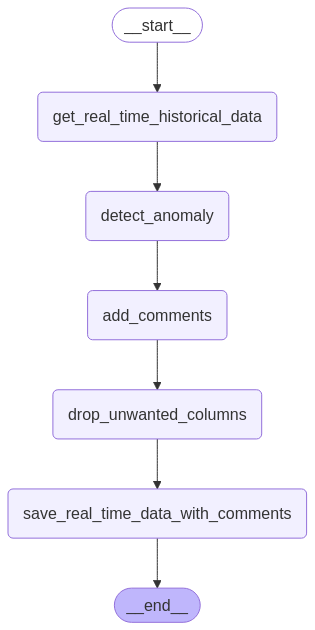

In [16]:
start_app()
